In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, pdist, squareform
import pprint

In [82]:
class undirected_chain():
    def __init__(self, psi, psi_2):
        """
        :param psi: list of array. The 1D array at position j corresponds to all possible values of log(psi_j),
        in the form of a vector
        :param psi_2: list of array. The 2D array at position j corresponds to all possible values of log(psi_j,j+1),
        in the form of a matrix
        
        Everything is saved on the log form
        """
        self.n = len(psi) # length of the chain
        self.psi = [np.log(v) for v in psi]
        self.psi_2 = [np.log(v) for v in psi_2]
        
        self.max_psi = [np.max(v) for v in self.psi]
        self.max_psi_2 = [np.max(v, axis=0) for v in self.psi_2]
        self.max_psi_2_rev = [np.max(v, axis=1) for v in self.psi_2] # used for beta
        
    def sum_product(self):
        """
        computes the forward and backward messages
        """
        # edge messages (alpha(0) and beta(n-1))
        self.alpha=[np.zeros(len(self.psi[0]))]
        self.beta=[np.zeros(len(self.psi[-1]))]
        
        # forward pass
        for j in range(self.n-1):
            term1 = self.max_psi[j] + self.max_psi_2[j] + np.max(self.alpha[-1])
            term2 = np.exp((self.psi[j]-self.max_psi[j])[:,None] + self.psi_2[j]-self.max_psi_2[j][None,:] + (self.alpha[-1]-np.max(self.alpha[-1]))[:,None])
            term = term1 + np.log(np.sum(term2, axis=0))
            self.alpha.append(term)
            
        # backward pass
        for j in range(self.n-2,-1,-1):
            term1 = self.max_psi[j+1] + self.max_psi_2_rev[j] + np.max(self.beta[-1])
            term2 = np.exp(self.psi[j+1]-self.max_psi[j+1] + self.psi_2[j]-self.max_psi_2_rev[j][:,None] + self.beta[-1]-np.max(self.beta[-1]))
            term = term1 + np.log(np.sum(term2, axis=1))
            self.beta.append(term)
            
    def normalize(self):
        """
        normalized the messages
        (unused)
        """
        self.alpha = [self.normalize_msg(alpha) for alpha in self.alpha]
        self.beta = [self.normalize_msg(beta) for beta in self.beta]
        
    def normalize_msg(self, msg):
        """
        normalized the messages
        (unused)
        """
        max_msg = np.max(msg)
        
        term1 = msg - max_msg
        term2 = np.exp(msg-max_msg)
        
        term = term1 - np.log(np.sum(term2))
        return term    
            
    def get_Z(self, j=-1, normalize=False):
        """
        computes Z directly
        :param j: node at which to compute Z
        :param normalize: whether to normalize messages
        """
        if not (self.alpha and self.beta):
            self.sum_product()
        if normalize:
            self.normalize()
        j = j%self.n
        Z = np.sum(np.exp(self.alpha[j] + self.psi[j] + self.beta[self.n-1-j]))
        return Z
    
    def get_log_Z(self, j=-1, normalize=False):
        """
        computes log(Z)
        :param j: node at which to compute Z
        :param normalize: whether to normalize messages
        """
        if not (self.alpha and self.beta):
            self.sum_product()
        if normalize:
            self.normalize()
        j = j%self.n
        term1 = np.max(self.alpha[j]) + self.max_psi[j] + np.max(self.beta[self.n-1-j])
        term2 = np.exp(self.alpha[j]-np.max(self.alpha[j]) + self.psi[j]-self.max_psi[j] + self.beta[self.n-1-j]-np.max(self.beta[self.n-1-j]))
        term = term1 + np.log(np.sum(term2))
        self.Z = term
        return self.Z
            
    def get_proba(self, j):
        """
        computes the probas at node j
        :param j: the node position
        """
        if not (self.alpha and self.beta):
            self.sum_product()
        if not self.Z:
            self.get_log_Z()
        j = j%self.n
        return np.exp(self.alpha[j] + self.psi[j] + self.beta[self.n-1-j] - self.Z)

In [83]:
# unit test

# initialize a small case
psi = [np.array([0.4, 0.6]), np.array([0.3, 0.7])]
psi_2 = [np.array([[0.1, 0.2],[0.3, 0.4]])]
ch = undirected_chain(psi, psi_2)
ch.sum_product()

# test on sum-product algorithm
print(np.allclose(ch.alpha[1], np.log(psi_2[0].T @ psi[0])))
print(np.allclose(ch.beta[1], np.log(psi_2[0] @ psi[1])))

# test on Z calculation
Z0 = (np.exp(ch.alpha[0])*np.exp(ch.beta[-1])) @ psi[0]
Z1 = (np.exp(ch.alpha[-1])*np.exp(ch.beta[0])) @ psi[1]

print(np.allclose(Z0, Z1))
print(np.allclose(Z0, ch.get_Z(0)))
print(np.allclose(Z0, ch.get_Z(-1)))

print(np.allclose(np.log(Z0), np.log(Z0)))
print(np.allclose(np.log(Z0), ch.get_log_Z(0)))
print(np.allclose(np.log(Z0), ch.get_log_Z(-1)))

True
True
True
True
True
True
True
True


In [84]:
# unit test

# initialize a small case (different number of values for nodes)
psi = [np.array([0.1, 0.4, 0.5]), np.array([0.3, 0.7])]
psi_2 = [np.array([[0.1, 0.2],[0.3, 0.4],[0.5, 0.6]])]
ch = undirected_chain(psi, psi_2)
ch.sum_product()

# test on sum-product algorithm
print(np.allclose(ch.alpha[1], np.log(psi_2[0].T @ psi[0])))
print(np.allclose(ch.beta[1], np.log(psi_2[0] @ psi[1])))

# test on Z calculation
Z0 = (np.exp(ch.alpha[0])*np.exp(ch.beta[-1])) @ psi[0]
Z1 = (np.exp(ch.alpha[-1])*np.exp(ch.beta[0])) @ psi[1]

print(np.allclose(Z0, Z1))
print(np.allclose(Z0, ch.get_Z(0)))
print(np.allclose(Z0, ch.get_Z(-1)))

print(np.allclose(np.log(Z0), np.log(Z0)))
print(np.allclose(np.log(Z0), ch.get_log_Z(0)))
print(np.allclose(np.log(Z0), ch.get_log_Z(-1)))

True
True
True
True
True
True
True
True


### Question 2

In [117]:
def ising_junction(beta, w=10, h=100):
    """
    For the Ising grid, returns the psi_j and psi_ij of the junction tree, in a suitable format to feed 
    the class undirected_chain and run the sum-product algorithm
    we assume alpha=0
    
    for psi_j, we have 2^w distinct values for (z_ij)j (in the form of a vector)
    for psi_ij, we have 2^w x 2^w distinct values for (z_ij)j x (z_ij)j (in the form of a matrix)
    
    the binary encoding of the index corresponds to the values of the z_ij of the row i
    """
    
    def nb_of_common_same_level(x):
        return (1-np.abs(np.diff(x, axis=1))).sum(axis=1)
    
    def nb_of_common_two_level(k1,k2):
        b1 = np.array([int(i) for i in list('{0:0b}'.format(k1).zfill(w))])
        b2 = np.array([int(i) for i in list('{0:0b}'.format(k2).zfill(w))])
        return nb_common_bits(b1,b2)
    
    def nb_common_bits(b1,b2):
        return (b1==b2).sum()
    
    def unpackbits(x,num_bits):
        xshape = list(x.shape)
        x = x.reshape([-1,1])
        to_and = 2**np.arange(num_bits).reshape([1,num_bits])
        return np.flip((x & to_and).astype(bool).astype(int).reshape(xshape + [num_bits]), axis=1)
        
    x = np.arange(2**w, dtype=np.uint32)
    y = unpackbits(x,w) # takes the binary encoding of each integer up to 2^w
    
    # nb of common values between two consecutive layers
    # calculates the number of common bits for two encodings and return the corresponding distance matrix
    dists = pdist(y, nb_common_bits) # for now, diagonal elements are 0
    different_layer = w * np.identity(2**w) + squareform(dists) # on the diagonal, we have w common bits (the whole row)
    
    # nb of equal consecutive values on the same layer
    same_layer = nb_of_common_same_level(y)
    
    # finally, compute psi and psi_2
    psi = [np.exp(beta*same_layer) for i in range(h)]
    psi_2 = [np.exp(beta*different_layer) for i in range(h-1)]
    
    return psi, psi_2

In [123]:
%%time
# computation for a small grid
psi, psi_2 = ising_junction(0, w=3, h=3)
ch = undirected_chain(psi, psi_2)
ch.sum_product()
Z = ch.get_log_Z(-1)
print(Z)

6.238324625039507
CPU times: user 2.55 ms, sys: 0 ns, total: 2.55 ms
Wall time: 2.17 ms


In [124]:
%%time
# computation for the grid of question 2
psi, psi_2 = ising_junction(0, w=10, h=100)
ch = undirected_chain(psi, psi_2)
ch.sum_product()
Z = ch.get_log_Z(-1)
print(Z)
# pprint.pprint(ch.alpha)

693.1471805599463
CPU times: user 7.43 s, sys: 1.37 s, total: 8.8 s
Wall time: 5.54 s


In [ ]:
# free RAM
ch = None

In [451]:
# bounds on Z
h=100
w=10
beta = np.concatenate((np.sort(-1*np.logspace(-3,2,6)), [0], np.logspace(-3,0,4)))

# lower bound
lower = np.exp((4*beta*(h-2)*(w-2)+3*beta*(2*(h-2)+2*(w-2))+2*beta*4)/2)

# upper bound
upper = 2**(h*w) * lower

/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


In [484]:
betas = np.concatenate((np.sort(-1*np.logspace(-3,2,6)), [0], np.logspace(-3,0,4)))
Zs = []
for beta in betas:
    print('Beta={}'.format(beta))
    psi, psi_2 = ising_junction(beta, w=10, h=100)
    ch = undirected_chain(psi, psi_2)
    ch.sum_product()
    Z = ch.get_log_Z(-1)
    Zs.append(Z)
    print('Found log(Z)={}'.format(Z))
Zs=np.array(Zs)

Beta=-100.0


/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Found log(Z)=0.6931471805599453
Beta=-10.0
Found log(Z)=0.6931471888251494
Beta=-1.0
Found log(Z)=44.54243324777186
Beta=-0.1
Found log(Z)=601.0142732271387
Beta=-0.01
Found log(Z)=683.720806018391
Beta=-0.001
Found log(Z)=692.2024168099916
Beta=0.0
Found log(Z)=693.1471805599463
Beta=0.001
Found log(Z)=694.0924168099921
Beta=0.01
Found log(Z)=702.6208060183924
Beta=0.1
Found log(Z)=790.0142732271373
Beta=1.0
Found log(Z)=1934.542433247772


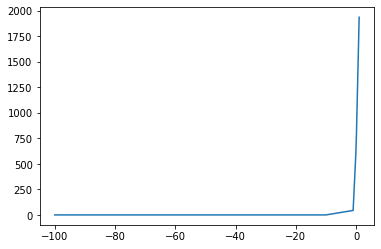

In [512]:
plt.plot(betas, Zs)
# plt.ylim(0,5)

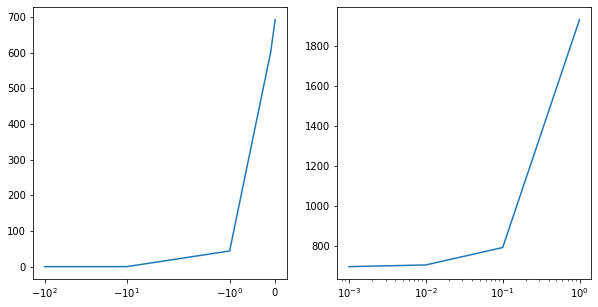

In [511]:
neg_betas_idx = np.where(betas<0)[0]
neg_betas = betas[neg_betas_idx]
neg_Zs = Zs[neg_betas_idx]

pos_betas_idx = np.where(betas>0)[0]
pos_betas = betas[pos_betas_idx]
pos_Zs = Zs[pos_betas_idx]

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(neg_betas, neg_Zs)
ax[1].plot(pos_betas, pos_Zs)
ax[0].set_xscale('symlog')
ax[1].set_xscale('log')

In [489]:
100*10*np.log(2)
np.log(2)

693.1471805599452

### Question 3

In [98]:
class Ising():
    def __init__(self, h, w, alpha, beta):
        """
        :param psi: list of array. The 1D array at position j corresponds to all possible values of psi_j
        :param psi_2: list of array. The 2D array at position j corresponds to all possible values of psi_j,j+1
        """
        self.h = h
        self.w = w
        
        self.edges = []
        for i in range(h-1):
            for j in range(w):
                self.edges.append(((i,j),(i+1,j)))
        for i in range(h):
            for j in range(w-1):
                self.edges.append(((i,j),(i,j+1)))
        self.edges += [(v2,v1) for (v1,v2) in self.edges] # take reverse order too
        
        self.nb_edges = len(self.edges)
                
        self.psi = np.tile(alpha * np.arange(2), (h,w,1)) # work on the log, again
        self.psi_2 = {(v1,v2): beta*np.identity(2) for (v1,v2) in self.edges} # on the log
        
        self.max_psi = np.max(self.psi, axis=-1)
        self.max_psi_2 = {k:np.max(v, axis=1) for k,v in self.psi_2.items()}
        
        self.alpha = None
        self.Z = None
        
    def LBP(self, n, kind='naive', normalize=True, verbose=False):
        # initialization
        if not self.alpha:
            self.init_alpha()
        
        # naive way
        if kind=='naive':
            for k in range(n):
                e = self.edges[np.random.randint(self.nb_edges)]
                self.update_msg(e, normalize=normalize, verbose=verbose)
        
        elif kind=='tree':
            for k in range(n):
                # extract a tree from the graph
                tree = self.extract_tree()
                for e in tree:
                    self.update_msg(e, normalize=normalize, verbose=verbose)
                for (v1,v2) in reversed(tree):
                    self.update_msg((v2,v1), normalize=normalize, verbose=verbose)
        else:
            raise(ValueError)
            
    def init_alpha(self, kind='naive'):
        print('Initialize alpha')
        
        if kind == 'naive':
            self.alpha={(v1,v2):np.zeros(2) for (v1,v2) in self.edges}
        elif kind == 'random':
            self.alpha={(v1,v2):np.random.normal(size=2) for (v1,v2) in self.edges}
        else:
            raise(ValueError)
            
#     def extract_tree(self):
#         e = self.edges[np.random.randint(self.nb_edges)]
#         (v1,v2) = e
#         taken = [(v1,v2), (v2,v1)] # we also forbid to take the contrary edge
        
#         while True:
#             children = list(set(self.get_children(e)).difference(set(taken)))
#             if children == []:
#                 break
#             child = children[np.random.randint(len(children))]
#             (s1,s2) = child
#             taken.append(child)
#             taken.append((s2,s1))
#         return taken
    
    def extract_tree(self):
        (i,j) = np.random.randint(self.h), np.random.randint(self.w)
        v = (i,j)
        taken = [v]
        
        while True:
            children = self.get_outcoming_edges(v)
            children_vertices = [child[1] for child in children] # take all vertices
            children_vertices = list(set(children_vertices).difference(set(taken)))
            if children_vertices == []:
                break
            child_vertex = children_vertices[np.random.randint(len(children_vertices))]
            taken.append(child_vertex)
            v = child_vertex
        return [(taken[i],taken[i+1]) for i in range(len(taken)-1)]
        
    def get_children(self, e):
        (v1,v2) = e
        return [(s1,s2) for (s1,s2) in self.edges if s1==v2 and s2!=v1]
    
    def get_parents(self, e):
        (v1,v2) = e
        return [(s1,s2) for (s1,s2) in self.edges if s2==v1 and s1!=v2]
    
    def get_incoming_edges(self, v):
        return [(s1,s2) for (s1,s2) in self.edges if s2==v]
    
    def get_outcoming_edges(self, v):
        return [(s1,s2) for (s1,s2) in self.edges if s1==v]
    
    def update_msg(self, e1, normalize=True, verbose=False):
        (v1,v2) = e1
        neighbors = self.get_parents(e1)
        max_msgs = np.zeros(2)
        for e2 in neighbors:
            max_msgs += np.max(self.alpha[e2])
        term1 = self.max_psi[v1] + self.max_psi_2[(v1,v2)] + max_msgs

        msgs = np.zeros(2)
        for e2 in neighbors:
            msgs += self.alpha[e2]
        term2 = np.exp((self.psi[v1]-self.max_psi[v1])[:,None] + self.psi_2[(v1,v2)]-self.max_psi_2[(v1,v2)][None,:] + (msgs-max_msgs)[:,None])
        
#         term2 = np.exp((self.psi[j]-self.max_psi[j])[:,None] + self.psi_2[j]-self.max_psi_2[j][None,:] + (self.alpha[-1]-np.max(self.alpha[-1]))[:,None])

        if verbose:
            print('msg : {}'.format(msgs))
#             print(term1)
#             print(term2)
        term = term1 + np.log(np.sum(term2, axis=0))
        if verbose:
            print('unormalized : {}'.format(term))
        if normalize:
            term = self.normalize_msg(term) # we normalize msgs
        if verbose:
            print('normalized : {}'.format(term))
        
        self.alpha[(v1,v2)] = term 
    
    def normalize_msg(self, msg):
        max_msg = np.max(msg)
        
        term1 = msg - max_msg
        term2 = np.exp(msg-max_msg)
        
        term = term1 - np.log(np.sum(term2))
        return term      
                      
    def get_Z(self, v=(0,0)):
        if not self.alpha:
            self.LBP()
        
        (i,j) = v
        i = i%self.h
        j = j%self.w
        v = (i,j)
        
        neighbors = self.get_incoming_edges(v)
        msgs = 0
        for e in neighbors:
            msgs += self.alpha[e]
        
        Z = np.sum(np.exp(self.psi[(i,j)] + msgs))
        return Z
    
    def get_log_Z(self, v=(0,0)):
        if not self.alpha:
            self.LBP()
            
        (i,j) = v
        i = i%self.h
        j = j%self.w
        v = (i,j)
        
        neighbors = self.get_incoming_edges(v)
        max_msgs = 0
        for e in neighbors:
            max_msgs += np.max(self.alpha[e])
        term1 = self.max_psi[i,j] + max_msgs

        msgs = np.zeros(2)
        for e in neighbors:
            msgs += self.alpha[e]
        term2 = np.exp((self.psi[i,j]-self.max_psi[i,j])[:,None] + (msgs-max_msgs)[:,None])
        term = term1 + np.log(np.sum(term2))
        self.Z = term
        return term
            
    def get_proba(self, v=(0,0)):
        if not self.alpha:
            self.LBP(500)
        
        self.get_log_Z(v)
            
        (i,j) = v
        i = i%self.h
        j = j%self.w
        v = (i,j)
        
        neighbors = self.get_incoming_edges(v)
        msgs = np.zeros(2)
        for e in neighbors:
            msgs += self.alpha[e]
        
        probas = np.exp(self.psi[i,j] + msgs - self.Z)
        return probas / np.sum(probas)
    
    def get_unnormed_proba(self, v=(0,0)):
        if not self.alpha:
            self.LBP()
        
        self.get_log_Z(v)
            
        (i,j) = v
        i = i%self.h
        j = j%self.w
        v = (i,j)
        
        neighbors = self.get_incoming_edges(v)
        msgs = np.zeros(2)
        for e in neighbors:
            msgs += self.alpha[e]
        
        probas = np.exp(self.psi[i,j] + msgs - self.Z)
        return probas
    
    def get_couple_proba(self, v1, v2):
        """
        returns the joint probabilities for a couple of adjacent vertices
        """
        if not self.alpha:
            self.LBP()
        if not self.Z:
            self.get_log_Z()
        if (v1,v2) not in self.edges:
            raise(ValueError)
            
        parents_1 = self.get_incoming_edges(v1)
        parents_2 = self.get_incoming_edges(v2)
        
        sum_1 = np.zeros(2)
        for e in parents_1:
            sum_1 += self.alpha[e]
        
        sum_2 = np.zeros(2)
        for e in parents_2:
            sum_2 += self.alpha[e]
            
        probas = np.exp(self.psi[v1][None,:] + self.psi[v2][:,None] + self.psi_2[(v1,v2)] + sum_1[None,:] + sum_2[:,None] - self.Z)
        
        return probas / np.sum(probas)
    
    def get_probas(self, v_list):
        edges = [(v1,v2) for i,v1 in enumerate(v_list[:-1]) for v2 in v_list[i+1:]]
        if edges == []:
            return get_proba
        for e in edges:
            if e not in self.edges:
                raise(ValueError)
        e = edges[0]
        sum_psi = np.outer(self.psi[v_list[0]], self.psi[v_list[1]]) * self.psi_2[(v_list[0], v_list[1])]
        old_v = v_list[1]
        for v in v_list[2:]:
            sum_psi = np.multiply.outer(sum_psi, self.psi[v]) * self.psi_2[(old_v, v)]
            old_v = v

    
    def check_msg(self):
        comp = {}
        i = 0
        for (v1,v2) in self.edges:
            if v1<=v2:
                comp[(v1,v2)] = self.alpha[(v1,v2)]-self.alpha[(v2,v1)]
        pprint.pprint(comp)
#         comp = np.zeros((int(self.nb_edges/2),2,2))
#         i = 0
#         for (v1,v2) in self.edges:
#             if v1<=v2:
#                 comp[i,0] = self.alpha[(v1,v2)]
#                 comp[i,1] = self.alpha[(v2,v1)]
#         print(comp[:,0]-comp[:,1])

In [33]:
# unit test
ising = Ising(h=3,w=3,alpha=1,beta=-1)


msg = np.exp(np.array([1,2]))
log_msg = np.log(msg)

norm_msg = msg/np.sum(msg)
norm_log_msg = np.log(norm_msg)

np.allclose(norm_log_msg, ising.normalize_msg(log_msg))

True

In [100]:
ising = Ising(h=100,w=10,alpha=0,beta=-1)
ising.init_alpha('random')
ising.LBP(500, 'tree', normalize=False, verbose=False)

Initialize alpha


In [112]:
ising.get_log_Z((0,0))-ising.alpha[((1,0),(0,0))]-ising.alpha[((0,1),(0,0))]

array([-4.74284398e+80, -4.74284398e+80])

In [116]:
ising.alpha[((1,0),(0,0))]

array([1.26256296e+96, 1.26256296e+96])

In [115]:
ising.alpha[((0,1),(0,0))]

array([3.78768888e+96, 3.78768888e+96])

In [111]:
print(ising.get_couple_proba((0,1),(0,0)))

[[nan nan]
 [nan nan]]


/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: overflow encountered in exp
/home/henric/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: invalid value encountered in true_divide


In [76]:
neighbors = ising.get_incoming_edges((0,0))
msg = np.zeros(2)
for e in neighbors:
    msg += ising.alpha[e]
    
ising.get_log_Z((0,0)) - msg

array([0.69314718, 0.69314718])

In [77]:
neighbors = ising.get_incoming_edges((1,2))
msg = np.zeros(2)
for e in neighbors:
    msg += ising.alpha[e]
    
ising.get_log_Z((1,2)) - msg

array([0.69314718, 0.69314718])

In [74]:
ising = Ising(h=3,w=3,alpha=0,beta=0)

In [75]:
ising.init_alpha('random')
ising.LBP(500, 'tree', normalize=True, verbose=False)

Initialize alpha


In [56]:
print(ising.get_log_Z())
print(ising.get_couple_proba((0,1),(0,0)))

print(ising.get_proba((0,0)))
print(ising.get_proba((1,1)))
print(ising.get_proba((2,1)))
print(ising.get_proba((3,3)))
print()
print(ising.get_unnormed_proba((0,0)))
print(ising.get_unnormed_proba((1,1)))
print(ising.get_unnormed_proba((2,1)))
print(ising.get_unnormed_proba((3,3)))

-0.6931471805599453
[[0.25 0.25]
 [0.25 0.25]]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]

[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]


In [30]:
print(ising.get_log_Z((0,0)))
print(ising.get_log_Z((1,1)))
print(ising.get_log_Z((1,2)))
print(ising.get_log_Z((2,2)))

-0.6931471805599453
-2.0794415416798357
-1.3862943611198904
-0.6931471805599453


In [ ]:
4-

In [32]:
4* -0.69314718 + 2*-1.3862943611198904+-2.0794415416798357

-7.624618983919616

In [ ]:
6.238324625039508

In [20]:
ising.alpha

{((0, 0), (1, 0)): array([-0.69314718, -0.69314718]),
 ((0, 1), (1, 1)): array([-0.69314718, -0.69314718]),
 ((0, 2), (1, 2)): array([-0.69314718, -0.69314718]),
 ((1, 0), (2, 0)): array([-0.69314718, -0.69314718]),
 ((1, 1), (2, 1)): array([-0.69314718, -0.69314718]),
 ((1, 2), (2, 2)): array([-0.69314718, -0.69314718]),
 ((0, 0), (0, 1)): array([-0.69314718, -0.69314718]),
 ((0, 1), (0, 2)): array([-0.69314718, -0.69314718]),
 ((1, 0), (1, 1)): array([-0.69314718, -0.69314718]),
 ((1, 1), (1, 2)): array([-0.69314718, -0.69314718]),
 ((2, 0), (2, 1)): array([-0.69314718, -0.69314718]),
 ((2, 1), (2, 2)): array([-0.69314718, -0.69314718]),
 ((1, 0), (0, 0)): array([-0.69314718, -0.69314718]),
 ((1, 1), (0, 1)): array([-0.69314718, -0.69314718]),
 ((1, 2), (0, 2)): array([-0.69314718, -0.69314718]),
 ((2, 0), (1, 0)): array([-0.69314718, -0.69314718]),
 ((2, 1), (1, 1)): array([-0.69314718, -0.69314718]),
 ((2, 2), (1, 2)): array([-0.69314718, -0.69314718]),
 ((0, 1), (0, 0)): array([-0

In [24]:
# unit test
h,w = 3,3
ising = Ising(h=h,w=w,alpha=0,beta=0)
ising.LBP(500, 'tree')
log_Z = ising.get_log_Z()
print(log_Z)
print(h*w*np.log(2))

print((ising.get_couple_proba((0,1),(0,0)) == ising.get_couple_proba((0,0),(0,1)).T).all())

Initialize alpha
-0.6931471805599453
6.238324625039508
True


In [1054]:
# test
psi, psi_2 = ising_junction(beta=0, w=3, h=3)
ch = undirected_chain(psi, psi_2)
ch.sum_product()
Z = ch.get_log_Z(-1)
Z

6.238324625039507

In [1181]:
ising.check_msg()

{((0, 0), (0, 1)): array([ 0.09617595, -0.12511825]),
 ((0, 0), (1, 0)): array([ 0.09617595, -0.12511825]),
 ((0, 1), (0, 2)): array([-0.09617595,  0.12511825]),
 ((0, 1), (1, 1)): array([-0.07957304,  0.09762336]),
 ((0, 2), (1, 2)): array([ 0.09617595, -0.12511825]),
 ((1, 0), (1, 1)): array([-0.07957304,  0.09762336]),
 ((1, 0), (2, 0)): array([-0.09617595,  0.12511825]),
 ((1, 1), (1, 2)): array([ 0.07957304, -0.09762336]),
 ((1, 1), (2, 1)): array([ 0.07957304, -0.09762336]),
 ((1, 2), (2, 2)): array([-0.09617595,  0.12511825]),
 ((2, 0), (2, 1)): array([ 0.09617595, -0.12511825]),
 ((2, 1), (2, 2)): array([-0.09617595,  0.12511825])}


In [13]:
ising.alpha

{((0, 0), (1, 0)): array([-0.52353323, -0.89752706]),
 ((0, 1), (1, 1)): array([-0.63683927, -0.75281585]),
 ((0, 2), (1, 2)): array([-0.52353323, -0.89752706]),
 ((1, 0), (2, 0)): array([-0.61970919, -0.77240881]),
 ((1, 1), (2, 1)): array([-0.55726624, -0.85043921]),
 ((1, 2), (2, 2)): array([-0.61970919, -0.77240881]),
 ((0, 0), (0, 1)): array([-0.52353323, -0.89752706]),
 ((0, 1), (0, 2)): array([-0.61970919, -0.77240881]),
 ((1, 0), (1, 1)): array([-0.63683927, -0.75281585]),
 ((1, 1), (1, 2)): array([-0.55726624, -0.85043921]),
 ((2, 0), (2, 1)): array([-0.52353323, -0.89752706]),
 ((2, 1), (2, 2)): array([-0.61970919, -0.77240881]),
 ((1, 0), (0, 0)): array([-0.61970919, -0.77240881]),
 ((1, 1), (0, 1)): array([-0.55726624, -0.85043921]),
 ((1, 2), (0, 2)): array([-0.61970919, -0.77240881]),
 ((2, 0), (1, 0)): array([-0.52353323, -0.89752706]),
 ((2, 1), (1, 1)): array([-0.63683927, -0.75281585]),
 ((2, 2), (1, 2)): array([-0.52353323, -0.89752706]),
 ((0, 1), (0, 0)): array([-0

In [1073]:
-np.log(2)

-0.6931471805599453